# Introduction

The Y2AVE project needs seqspecs that use filenames available on synapse.

- [Python environment](#Setup)
- [Defining the template](#Defining-the-template)
  - [Print example seqspec](#Print-example-seqspec)
- [Generate team seqspec tarfile](#Generate-team-seqspec-tarfile)

There's roughly two sections to this notebook, the first is designe


# Connecting teams to seqspecs

This spreadsheet has the longer descriptions of the datasets and what team they were assigned to. 
[IGVF Single Cell datasets for Y2AVE](https://docs.google.com/spreadsheets/d/1QWa1JUzs7pR02P8uS95MWIqW8-Ldh7BX6D990YXXQbQ/edit#gid=0)

<table>
    <thead>
        <tr><td>Team></td><td>Chemistry</td><td>Seqspec</td><tr>
    </thead>
    <tbody>
        <tr><td>Team 1</td><td>10x_multiome</td><td>characterization_mcginnis</td><tr>
        <tr><td>Team 2</td><td>10x_multiome</td><td>characterization_mcginnis (is there 2 for team 2?)</td><tr>
        <tr><td>Team 3</td><td>10x_multiome</td><td></td><tr>
        <tr><td>Team 4</td><td>10x_v2</td>      <td></td><tr>
        <tr><td>Team 5</td><td>10x_multiome</td><td></td><tr>
        <tr><td>Team 6</td><td>10x_v2</td>      <td>10xsnatac</td><tr>
        <tr><td>Team 7</td><td>10x_multiome</td><td>10xmultiome_bridge_satpathy</td><tr>
        <tr><td>Team 7</td><td>parse</td>       <td>parse_bridge</td><tr>
        <tr><td>Team 8</td><td>shareseq</td>    <td>shareseq_bmmc_single_donor</td><tr>
    </tbody>
</table>

This synapse folder contains the snapshots of the AnVIL tables created during the first Y2AVE jamboree.
[Tables from past jamborees](https://drive.google.com/drive/folders/11LwkduQZTqKolIodTZywoUj0N2apIz41)
The notebook as it currently is written expects to find those files present in the current directory.

More work needs to be done to match datasets to seqspec templates.

# Setup

First we start with general imports

In [1]:
import hashlib
import requests
from pathlib import Path
from io import StringIO, BytesIO
import sys
import json
from jsonschema import Draft4Validator
import logging
import pandas
import os
import sys
import tarfile
from urllib.parse import urlparse
import yaml

In [2]:
try:
    from jinja2 import Environment
except ImportError:
    !{sys.executable} -m pip install --user jinja2
    from jinja2 import Environment

from jinja2 import FileSystemLoader, select_autoescape, Undefined, StrictUndefined, make_logging_undefined

logger = logging.getLogger(__name__)
LoggingUndefined = make_logging_undefined(
    logger=logger,
    base=Undefined
)

env = Environment(
    loader=FileSystemLoader("templates"),
    autoescape=select_autoescape(),
    undefined=LoggingUndefined,
)

I want to be able to use the seqspec validator while I was writing my seqspec file.

I have the repository checked out into ~/proj/seqspec. This block should either import it for me, or install it if someone elese runs it.

In [3]:
try:
    import seqspec
except ImportError:
    seqspec_root = Path("~/proj/seqspec").expanduser()
    if seqspec_root.exists() and str(seqspec_root) not in sys.path:
        sys.path.append(str(seqspec_root))
    else:
        !{sys.executable} -m pip install --user seqspec
    import seqspec

Import pieces of seqspec that we need for this notebook.

In [4]:
from seqspec.Assay import Assay
from seqspec.Region import Region
from seqspec.Region import Onlist
from seqspec.utils import load_spec_stream
from seqspec.seqspec_index import run_index, get_index
from seqspec.seqspec_print import run_print_sequence_spec, run_print_library_tree, run_print_library_png
from seqspec.seqspec_onlist import (
    run_list_onlists, run_onlist_read, run_onlist_region, run_onlist_region_type, run_find_by_type
)

## define seqspec validation functions

In [5]:
def seqspec_validate(schema, spec):
    """Validate a yaml object against a json schema
    """
    validator = Draft4Validator(schema)

    for idx, error in enumerate(validator.iter_errors(spec), 1):
        print(f"[{idx}] {error.message}")

In [6]:
def generate_seqspec_index(spec, row):
    modalities = [
        ("atac", "chromap", ("ATAC_fastq_R1", "ATAC_fastq_R2","ATAC_barcode")),
        ("rna", "kb", ("RNA_fastq_R1", "RNA_fastq_R2")),
        #("rna", "starsolo", ("RNA_fastq_R1", "RNA_fastq_R2")),
    ]
    args = {}
    for (modality, tool, names) in modalities:
        if len(names) > 0 and row.get(names[0]) is not None and len(row[names[0]]) > 0:
            fastqs = [Path(x).name for x in next(zip(*(row[x] for x in names)))]
            print(fastqs)

            args[tool] = run_index(spec, modality, fastqs, fmt=tool)
    return args

def validate_seqspec_onlist(spec, row):
    """Check that the onlist calculated by seqspec matches the table
    """
    modalities = [
        # modality, format, read1_name, barcode_name
        ("atac", "product", "ATAC_fastq_R1", "Barcode_inclusion_list_ATAC"),
        ("rna", "multi", "RNA_fastq_R1", "Barcode_inclusion_list_RNA"),
    ]
    # Team 8 has a single barcode column Barcode_inclusion_list which I guess applies to both?
    def get_barcode(row, barcode_name):
        for name in [barcode_name, "Barcode_inclusion_list"]:
            if name in row:
                return row[name]
        return []
    
    barcodes = {}
    for modality, onlist_format, r1_name, barcode_name in modalities:
        if row.get(r1_name) is not None and len(row.get(r1_name)) > 0:
            regions = run_find_by_type(spec, modality, "barcode")
            onlist_filenames = [x.onlist.filename for x in regions]
            found_filenames = set(onlist_filenames)
            expected_filenames = set([Path(x).name for x in get_barcode(row, barcode_name)])
            if expected_filenames == {"parse-splitseq-v2.tar.gz"}:
                expected_filenames = {'CB1.txt', 'CB23.txt'}
            elif expected_filenames == {"sai_192_whitelist.txt"}:
                expected_filenames = {"R1_human_barcodes.txt", "R2_human_barcodes.txt", "R3_human_barcodes.txt"}

            if found_filenames != expected_filenames:
                raise ValueError("Barcodes for modality {} don't match '{}', '{}'".format(
                    modality, found_filenames, expected_filenames))
            barcodes[modality] = onlist_filenames
            
    return barcodes

In [7]:
schema_path = seqspec_root / "seqspec"/ "schema" / "seqspec.schema.json"

with open(schema_path, "rt") as instream:
    seqspec_schema = json.load(instream)

In [8]:
def load_spec(filename):
    with open(filename, "rt") as instream:
        data = yaml.load(instream, Loader=yaml.Loader)
        for r in data.assay_spec:
            r.set_parent_id(None)
    return data

## Functions for loading the team tables

In [9]:
def parse_list_field(cell):
    if cell is None:
        return []
    elif len(cell) < 2:
        return []
    elif cell in ("[]", "['']", '[""]'):
        return []

    if cell[0] == "[" and cell[-1] == "]":
        values = []
        for element in cell[1:-1].split(","):
            values.append(element[1:-1])
        return values
    else:
        return [cell]
    
assert parse_list_field("['']") == []
assert parse_list_field("") == []
assert parse_list_field('["x/next1_B01_13A_R1.fastq.gz","x/next2_B01_13A_R1.fastq.gz"]') == ['x/next1_B01_13A_R1.fastq.gz', 'x/next2_B01_13A_R1.fastq.gz']

In [10]:
def load_team_table(team_id):
    team = pandas.read_csv(
        Path(f"{team_id}.tsv"), 
        sep="\t",
        converters = {
            "ATAC_barcode": parse_list_field,
            "ATAC_fastq_R1": parse_list_field, 
            "ATAC_fastq_R2": parse_list_field,
            "Barcode_inclusion_list_ATAC": parse_list_field,
            "RNA_fastq_R1": parse_list_field,
            "RNA_fastq_R2": parse_list_field,
            "Barcode_inclusion_list_RNA": parse_list_field,
            "Barcode_inclusion_list": parse_list_field,
        }

    )
    return team

## Load all the teams to see what the columns and chemistry values look like

In [11]:
teams = ["Team_1", "Team_2", "Team_3", "Team_4", "Team_5", "Team_6", "Team_7", "Team_8"]

for team_id in teams:
    table = load_team_table(team_id)
    print(team_id, set(table["Chemistry"]), table.columns)

Team_1 {'10x_multiome'} Index(['entity:Team_1_id', 'ATAC_barcode', 'ATAC_barcode_offset',
       'ATAC_fastq_R1', 'ATAC_fastq_R2', 'Barcode_inclusion_list_ATAC',
       'Barcode_inclusion_list_RNA', 'Chemistry', 'Genome', 'genome_tsv',
       'html_summary', 'joint_barcode_metadata', 'reference_fasta',
       'RNA_fastq_R1', 'RNA_fastq_R2', 'share_atac_barcode_metadata',
       'share_atac_filter_fragments', 'share_atac_filter_fragments_index',
       'share_rna_barcode_metadata', 'share_rna_final_bam', 'share_rna_h5',
       'share_rna_starsolo_raw_tar', 'Subpool'],
      dtype='object')
Team_2 {'10x_multiome'} Index(['entity:Team_2_id', 'ATAC_barcode', 'ATAC_barcode_offset',
       'ATAC_fastq_R1', 'ATAC_fastq_R2', 'Barcode_inclusion_list_ATAC',
       'Barcode_inclusion_list_RNA', 'Chemistry', 'Genome', 'genome_tsv',
       'html_summary', 'joint_barcode_metadata', 'reference_fasta',
       'RNA_fastq_R1', 'RNA_fastq_R2', 'share_atac_barcode_metadata',
       'share_atac_filter_frag

# Defining the template

First build up lists of barcodes onlists needed for this protocol the names will be passed to the template.

In [12]:
# this dictionary is team_id: Chemistry: template_filename

y2ave_templates = {
    "Team_1": { # filename in example seqspec matched Team_1.tsv
        "10x_multiome": "y2ave_characterization_mcginnis.yaml.j2",
    },
    "Team_2": { # filenames in table reference CharacterizationMcGinnis
        "10x_multiome": "y2ave_characterization_mcginnis.yaml.j2",        
    },
    "Team_3": {
        "10x_multiome": "y2ave_10xmultiome_bridge_satpathy.yaml.j2",
        "10x_v2": "y2ave_10xsnatac.yaml.j2",
    },
    "Team_4": {
        "10x_v2": "y2ave_10xsnatac.yaml.j2",
    },
    "Team_5": {
        "10x_multiome": "y2ave_10xmultiome_bridge_satpathy.yaml.j2",
        "10x_v2": "y2ave_10xsnatac.yaml.j2",
    },
    "Team_6": { # filename in example seqspec matched Team_6.tsv
        "10x_v2": "y2ave_10xsnatac.yaml.j2",
        "10x_multiome": "y2ave_10xmultiome_bridge_satpathy.yaml.j2",
    },
    "Team_7": { # my team
        "10x_multiome": "y2ave_10xmultiome_bridge_satpathy.yaml.j2",
        "parse": "y2ave_parse_bridge.yaml.j2",
    },
    "Team_8": { # only one shareseq team
        "shareseq": "y2ave_shareseq_bmmc_single_donor.yaml.j2",
    }
}

def format_template_filename(filenames):
    if len(filenames) == 0:
        return ""
    else:
        return Path(filenames[0]).name

def render_seqspec(team_id, row):
    context = {
        "ATAC_barcode": format_template_filename(row.get("ATAC_barcode", [])),
        "ATAC_fastq_R1": format_template_filename(row.get("ATAC_fastq_R1", [])),
        "ATAC_fastq_R2": format_template_filename(row.get("ATAC_fastq_R2", [])),
        "Barcode_inclusion_list_ATAC": format_template_filename(row.get("Barcode_inclusion_list_ATAC", [])),
        "RNA_fastq_R1": format_template_filename(row.get("RNA_fastq_R1", [])),
        "RNA_fastq_R2": format_template_filename(row.get("RNA_fastq_R2", [])),
        "Barcode_inclusion_list_RNA": format_template_filename(row.get("Barcode_inclusion_list_RNA", [])),
        "Barcode_inclusion_list": format_template_filename(row.get("Barcode_inclusion_list", [])),
        
    }

    # load the template and instantiate it with the context for this specific measurement set.
    # this version needs the libspec branch that separates the sequence and library specifications
    template = env.get_template(y2ave_templates[team_id][row["Chemistry"]])

    # this version needs the original version that merges the sequence and library specification concepts
    #parse_wt_mega_v2 = env.get_template("parse-wt-mega-v2-single-index-seqspec-0.yaml.j2")

    example_yaml = template.render(context)

    # validate the generated seqspec file.
    example_spec = load_spec_stream(StringIO(example_yaml))
    seqspec_validate(seqspec_schema, example_spec.to_dict())
    
    args = generate_seqspec_index(example_spec, row)
    onlists = validate_seqspec_onlist(example_spec, row)
    
    return example_yaml

## print example seqspec

Change the team id and iloc (0-based row number) to generate different specific seqspecs

In [13]:
# Print the example for evaluation.
team_id = "Team_7"
example_table = load_team_table(team_id)
example_row = example_table.iloc[1]
print(team_id, example_row["Chemistry"])
example_yaml = render_seqspec(team_id, example_row)
print(example_yaml)

Template variable warning: 'Barcode_inclusion_list_RNA_md5' is undefined
Template variable warning: 'Barcode_inclusion_list_ATAC_md5' is undefined


Team_7 10x_multiome
[1] None is not of type 'string'
[2] None is not of type 'string'
['ATAC_102_S2_L001_R1_001.fastq.gz', 'ATAC_102_S2_L001_R3_001.fastq.gz', 'ATAC_102_S2_L001_R2_001.fastq.gz']
['RNA_102_S2_L004_R1_001.fastq.gz', 'RNA_102_S2_L004_R2_001.fastq.gz']
!Assay
seqspec_version: 0.1.1
assay_id: 10xMultiome
name: 10x-ATAC-RNA
doi: https://www.globenewswire.com/en/news-release/2020/09/15/2093690/0/en/10x-Genomics-First-to-Market-With-Product-to-Simultaneously-Capture-Epigenome-and-Transcriptome.html
date: 15 September 2020
description: Single Cell Multiome ATAC + Gene Expression
modalities:
- rna
- atac
lib_struct: https://teichlab.github.io/scg_lib_structs/methods_html/10xChromium_multiome.html
library_protocol: Any
library_kit: Illumina Truseq Dual Index
sequence_protocol: Illumina NovaSeq 6000
sequence_kit: NovaSeq 6000 v1.5
sequence_spec:
- !Read
  read_id: RNA_102_S2_L004_R1_001.fastq.gz
  name: Read 1
  modality: rna
  primer_id: rna-truseq_read1
  min_len: 28
  max_len: 

In [14]:
%debug

ERROR:root:No traceback has been produced, nothing to debug.


## generate seqspec charts

Intended to help double check the seqspec file

In [15]:
example_spec = load_spec_stream(StringIO(example_yaml))
print(run_print_library_tree(example_spec))

                                                    ┌─'rna-illumina_p5:29'
                                                    ├─'rna-truseq_read1:29'
                                                    ├─'rna-cell_barcode:16'
                                                    ├─'rna-umi:12'
                          ┌─rna─────────────────────┤
                          │                         ├─'rna-cDNA:100'
                          │                         ├─'rna-truseq_read2:34'
                          │                         ├─'rna-index7:8'
                          │                         └─'rna-illumina_p7:24'
──────────────────────────┤
                          │                         ┌─'atac-illumina_p5:29'
                          │                         ├─'atac-cell_barcode:16'
                          │                         ├─'atac-linker:8'
                          │                         ├─'atac-nextera_read1:33'
                          └─atac──

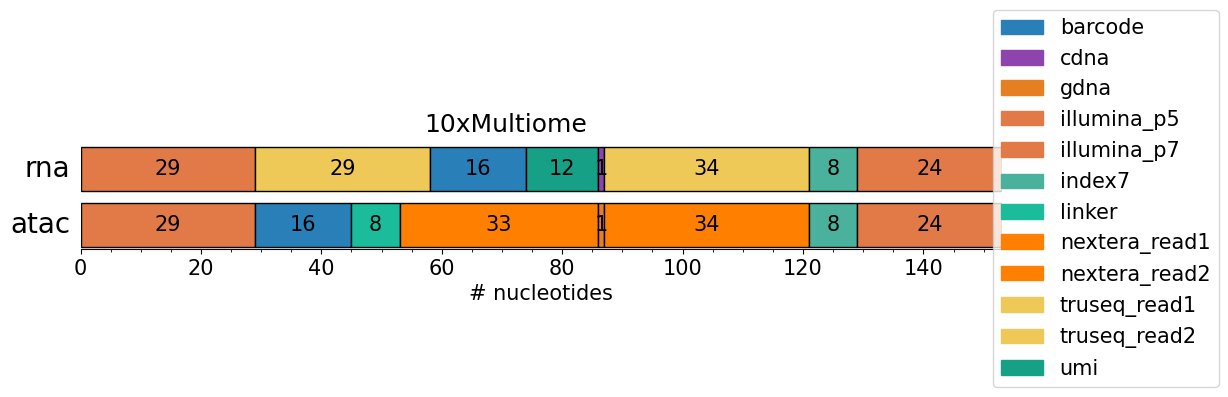

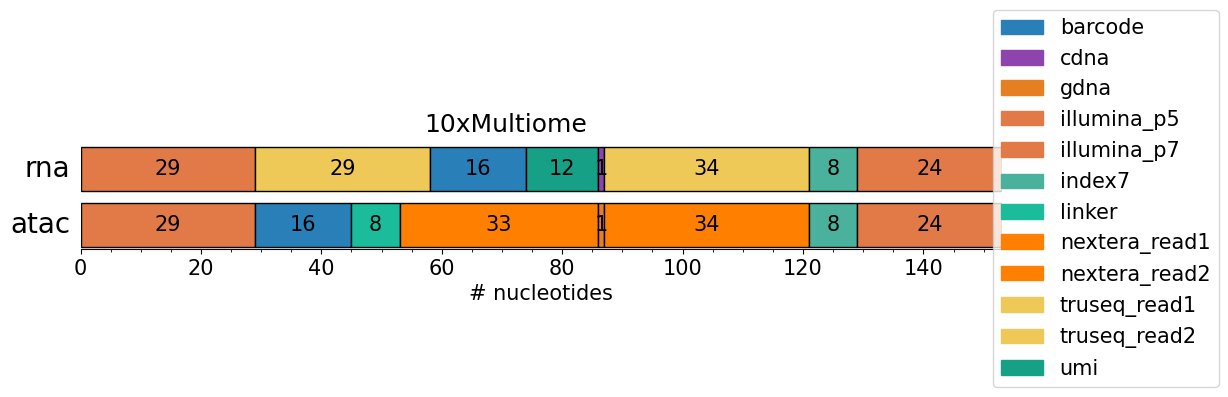

In [16]:
run_print_library_png(example_spec)

# generate tool arguments from seqspec index command

In [17]:
generate_seqspec_index(example_spec, example_row)

['ATAC_102_S2_L001_R1_001.fastq.gz', 'ATAC_102_S2_L001_R3_001.fastq.gz', 'ATAC_102_S2_L001_R2_001.fastq.gz']
['RNA_102_S2_L004_R1_001.fastq.gz', 'RNA_102_S2_L004_R2_001.fastq.gz']


{'chromap': '-1 ATAC_102_S2_L001_R1_001.fastq.gz -2 ATAC_102_S2_L001_R3_001.fastq.gz --barcode ATAC_102_S2_L001_R2_001.fastq.gz --read-format bc:8:24,r1:0:100,r2:0:100',
 'kb': '0,0,16:0,16,28:1,0,90'}

## print example onlist

In [18]:
validate_seqspec_onlist(example_spec, example_row)

{'atac': ['737K-arc-v1_ATAC_whitelist.txt.gz'],
 'rna': ['737K-arc-v1_GEX_whitelist.txt.gz']}

# Generate team seqspec tarfile

Once everything looks good, generate a tarfile of all the seqspecs for a team table change team_id here to pick the table you want.

In [19]:
def save_team_seqspecs_targz(team_id, table):
    destination = f"{team_id}_seqspecs.tar.gz"
    with tarfile.open(destination, "w:gz") as archive:
        for i, row in table.iterrows():
            row_name = row[0]
            print("Processing {}".format(row_name))
            spec_yaml = render_seqspec(team_id, row)
            spec_stream = BytesIO(spec_yaml.encode("utf-8"))
            spec_filename = f"{team_id}_{row_name}_seqspec.yaml"
            spec_tarinfo = tarfile.TarInfo(str(spec_filename))
            spec_tarinfo.size = len(spec_yaml)
            archive.addfile(spec_tarinfo, fileobj=spec_stream)


def save_team_seqspecs_directory(destination, team_id, table):
    arguments = []
    raw_url = "https://raw.githubusercontent.com/detrout/y2ave_seqspecs/main/{filename}"
    
    for i, row in table.iterrows():
        row_name = row[0]
        print("Processing {} {}".format(team_id, row_name))
        spec_filename = f"{team_id}_{row_name}_seqspec.yaml"
        spec_yaml = render_seqspec(team_id, row)
        with open(destination/spec_filename, "wt") as outstream:
            outstream.write(spec_yaml)
            
        spec = load_spec_stream(StringIO(spec_yaml))
        arg_row = {
            "team_id": team_id,
            "dataset_id": row_name,
            "url": raw_url.format(filename=spec_filename),
        }
        print(generate_seqspec_index(spec, row))
        arg_row.update(generate_seqspec_index(spec, row))
        arguments.append(arg_row)

    return arguments

arguments = []
destination = Path("~/proj/y2ave_seqspecs").expanduser()

for team_id in ["Team_1", "Team_2", "Team_3", "Team_4", "Team_7", "Team_8"]:
    print(f"Processing {team_id}")
    arguments.extend(save_team_seqspecs_directory(destination, team_id, load_team_table(team_id)))
    
pandas.DataFrame(arguments).to_csv(destination/"all_arguments.tsv", sep="\t", index=False)    

Processing Team_1
Processing Team_1 230601_iPSC_art_ven_EC_10Xmultiome_S1
[1] None is not of type 'string'
[2] None is not of type 'string'
[3] None is not of type 'string'
[4] None is not of type 'string'
['ATAC_1_S1_L001_R1_001.fastq.gz', 'ATAC_1_S1_L001_R3_001.fastq.gz', 'ATAC_1_S1_L001_R2_001.fastq.gz']
['GEX_1_S1_L001_R1_001.fastq.gz', 'GEX_1_S1_L001_R2_001.fastq.gz']
['ATAC_1_S1_L001_R1_001.fastq.gz', 'ATAC_1_S1_L001_R3_001.fastq.gz', 'ATAC_1_S1_L001_R2_001.fastq.gz']
['GEX_1_S1_L001_R1_001.fastq.gz', 'GEX_1_S1_L001_R2_001.fastq.gz']
{'chromap': '-1 ATAC_1_S1_L001_R1_001.fastq.gz -2 ATAC_1_S1_L001_R3_001.fastq.gz --barcode ATAC_1_S1_L001_R2_001.fastq.gz --read-format bc:8:24,r1:0:50,r2:0:98', 'kb': '0,0,16:0,16,28:1,0,90'}
['ATAC_1_S1_L001_R1_001.fastq.gz', 'ATAC_1_S1_L001_R3_001.fastq.gz', 'ATAC_1_S1_L001_R2_001.fastq.gz']
['GEX_1_S1_L001_R1_001.fastq.gz', 'GEX_1_S1_L001_R2_001.fastq.gz']
Processing Team_1 230601_iPSC_art_ven_EC_10Xmultiome_S2
[1] None is not of type 'string'
[2

['ATAC2_S54_L003_R1_001.fastq.gz', 'ATAC2_S54_L003_R3_001.fastq.gz', 'ATAC2_S54_L003_R2_001.fastq.gz']
['GEX2_S2_L003_R1_001.fastq.gz', 'GEX2_S2_L003_R2_001.fastq.gz']
{'chromap': '-1 ATAC2_S54_L003_R1_001.fastq.gz -2 ATAC2_S54_L003_R3_001.fastq.gz --barcode ATAC2_S54_L003_R2_001.fastq.gz --read-format bc:8:24,r1:0:50,r2:0:98', 'kb': '0,0,16:0,16,28:1,0,90'}
['ATAC2_S54_L003_R1_001.fastq.gz', 'ATAC2_S54_L003_R3_001.fastq.gz', 'ATAC2_S54_L003_R2_001.fastq.gz']
['GEX2_S2_L003_R1_001.fastq.gz', 'GEX2_S2_L003_R2_001.fastq.gz']
Processing Team_1 CharacterizationMcGinnis_Dataset10_10X_lane1


[1] None is not of type 'string'
[2] None is not of type 'string'
[3] None is not of type 'string'
[4] None is not of type 'string'
['ATAC_1_S130_L007_R1_001.fastq.gz', 'ATAC_1_S130_L007_R3_001.fastq.gz', 'ATAC_1_S130_L007_R2_001.fastq.gz']
['GEX_1_CMAS_IGVF10_R_S9_L004_R1_001.fastq.gz', 'GEX_1_CMAS_IGVF10_R_S9_L004_R2_001.fastq.gz']
['ATAC_1_S130_L007_R1_001.fastq.gz', 'ATAC_1_S130_L007_R3_001.fastq.gz', 'ATAC_1_S130_L007_R2_001.fastq.gz']
['GEX_1_CMAS_IGVF10_R_S9_L004_R1_001.fastq.gz', 'GEX_1_CMAS_IGVF10_R_S9_L004_R2_001.fastq.gz']
{'chromap': '-1 ATAC_1_S130_L007_R1_001.fastq.gz -2 ATAC_1_S130_L007_R3_001.fastq.gz --barcode ATAC_1_S130_L007_R2_001.fastq.gz --read-format bc:8:24,r1:0:50,r2:0:98', 'kb': '0,0,16:0,16,28:1,0,90'}
['ATAC_1_S130_L007_R1_001.fastq.gz', 'ATAC_1_S130_L007_R3_001.fastq.gz', 'ATAC_1_S130_L007_R2_001.fastq.gz']
['GEX_1_CMAS_IGVF10_R_S9_L004_R1_001.fastq.gz', 'GEX_1_CMAS_IGVF10_R_S9_L004_R2_001.fastq.gz']
Processing Team_1 CharacterizationMcGinnis_Dataset10_10X_

['ATAC_2_S359_L007_R1_001.fastq.gz', 'ATAC_2_S359_L007_R3_001.fastq.gz', 'ATAC_2_S131_L007_R2_001.fastq.gz']
['GEX_2_S42_L007_R1_001.fastq.gz', 'GEX_2_S42_L007_R2_001.fastq.gz']
{'chromap': '-1 ATAC_2_S359_L007_R1_001.fastq.gz -2 ATAC_2_S359_L007_R3_001.fastq.gz --barcode ATAC_2_S131_L007_R2_001.fastq.gz --read-format bc:8:24,r1:0:50,r2:0:98', 'kb': '0,0,16:0,16,28:1,0,90'}
['ATAC_2_S359_L007_R1_001.fastq.gz', 'ATAC_2_S359_L007_R3_001.fastq.gz', 'ATAC_2_S131_L007_R2_001.fastq.gz']
['GEX_2_S42_L007_R1_001.fastq.gz', 'GEX_2_S42_L007_R2_001.fastq.gz']
Processing Team_1 CharacterizationMcGinnis_Dataset2_10X_Lane_1
[1] None is not of type 'string'
[2] None is not of type 'string'
[3] None is not of type 'string'
[4] None is not of type 'string'
['ATAC_3_S360_L007_R1_001.fastq.gz', 'ATAC_3_S360_L007_R3_001.fastq.gz', 'ATAC_3_S360_L007_R2_001.fastq.gz']
['GEX_3_S43_L007_R1_001.fastq.gz', 'GEX_3_S43_L007_R2_001.fastq.gz']
['ATAC_3_S360_L007_R1_001.fastq.gz', 'ATAC_3_S360_L007_R3_001.fastq.gz',

['ATAC_2-_S2_L001_R1_001.fastq.gz', 'ATAC_2-_S2_L001_R3_001.fastq.gz', 'ATAC_2-_S2_L001_R2_001.fastq.gz']
['GEX_2_S2_L001_R1_001.fastq.gz', 'GEX_2_S2_L001_R2_001.fastq.gz']
{'chromap': '-1 ATAC_2-_S2_L001_R1_001.fastq.gz -2 ATAC_2-_S2_L001_R3_001.fastq.gz --barcode ATAC_2-_S2_L001_R2_001.fastq.gz --read-format bc:8:24,r1:0:50,r2:0:98', 'kb': '0,0,16:0,16,28:1,0,90'}
['ATAC_2-_S2_L001_R1_001.fastq.gz', 'ATAC_2-_S2_L001_R3_001.fastq.gz', 'ATAC_2-_S2_L001_R2_001.fastq.gz']
['GEX_2_S2_L001_R1_001.fastq.gz', 'GEX_2_S2_L001_R2_001.fastq.gz']
Processing Team_1 CharacterizationMcGinnis_Dataset3_10XLane_3
[1] None is not of type 'string'
[2] None is not of type 'string'
[3] None is not of type 'string'
[4] None is not of type 'string'
['ATAC_3-_S3_L001_R1_001.fastq.gz', 'ATAC_3-_S3_L001_R3_001.fastq.gz', 'ATAC_3-_S3_L001_R2_001.fastq.gz']
['GEX_3_S3_L001_R1_001.fastq.gz', 'GEX_3_S3_L001_R2_001.fastq.gz']
['ATAC_3-_S3_L001_R1_001.fastq.gz', 'ATAC_3-_S3_L001_R3_001.fastq.gz', 'ATAC_3-_S3_L001_R2_

['_ATAC_2_S6_L003_R1_001.fastq.gz', '_ATAC_2_S6_L003_R3_001.fastq.gz', '_ATAC_2_S6_L003_R2_001.fastq.gz']
['GEX_2-_S10_L003_R1_001.fastq.gz', 'GEX_2-_S10_L003_R2_001.fastq.gz']
{'chromap': '-1 _ATAC_2_S6_L003_R1_001.fastq.gz -2 _ATAC_2_S6_L003_R3_001.fastq.gz --barcode _ATAC_2_S6_L003_R2_001.fastq.gz --read-format bc:8:24,r1:0:50,r2:0:98', 'kb': '0,0,16:0,16,28:1,0,90'}
['_ATAC_2_S6_L003_R1_001.fastq.gz', '_ATAC_2_S6_L003_R3_001.fastq.gz', '_ATAC_2_S6_L003_R2_001.fastq.gz']
['GEX_2-_S10_L003_R1_001.fastq.gz', 'GEX_2-_S10_L003_R2_001.fastq.gz']
Processing Team_1 CharacterizationMcGinnis_Dataset7_10X_Lane_1_human
[1] None is not of type 'string'
[2] None is not of type 'string'
[3] None is not of type 'string'
[4] None is not of type 'string'
['ATAC_1__S1_L001_R1_001.fastq.gz', 'ATAC_1__S1_L001_R3_001.fastq.gz', 'ATAC_1__S1_L001_R2_001.fastq.gz']
['GEX_1-_S23_L005_R1_001.fastq.gz', 'GEX_1-_S23_L005_R2_001.fastq.gz']
['ATAC_1__S1_L001_R1_001.fastq.gz', 'ATAC_1__S1_L001_R3_001.fastq.gz', '

['ATAC_2__S2_L001_R1_001.fastq.gz', 'ATAC_2__S2_L001_R3_001.fastq.gz', 'ATAC_2__S2_L001_R2_001.fastq.gz']
['GEX_2-_S24_L005_R1_001.fastq.gz', 'GEX_2-_S24_L005_R2_001.fastq.gz']
{'chromap': '-1 ATAC_2__S2_L001_R1_001.fastq.gz -2 ATAC_2__S2_L001_R3_001.fastq.gz --barcode ATAC_2__S2_L001_R2_001.fastq.gz --read-format bc:8:24,r1:0:50,r2:0:98', 'kb': '0,0,16:0,16,28:1,0,90'}
['ATAC_2__S2_L001_R1_001.fastq.gz', 'ATAC_2__S2_L001_R3_001.fastq.gz', 'ATAC_2__S2_L001_R2_001.fastq.gz']
['GEX_2-_S24_L005_R1_001.fastq.gz', 'GEX_2-_S24_L005_R2_001.fastq.gz']
Processing Team_1 CharacterizationMcGinnis_Dataset7_10X_Lane_3_human
[1] None is not of type 'string'
[2] None is not of type 'string'
[3] None is not of type 'string'
[4] None is not of type 'string'
['ATAC_3__S3_L001_R1_001.fastq.gz', 'ATAC_3__S3_L001_R3_001.fastq.gz', 'ATAC_3__S3_L001_R2_001.fastq.gz']
['GEX_3-_S25_L005_R1_001.fastq.gz', 'GEX_3-_S25_L005_R2_001.fastq.gz']
['ATAC_3__S3_L001_R1_001.fastq.gz', 'ATAC_3__S3_L001_R3_001.fastq.gz', '

['ATAC_4__S4_L001_R1_001.fastq.gz', 'ATAC_4__S4_L001_R3_001.fastq.gz', 'ATAC_4__S4_L001_R2_001.fastq.gz']
['GEX_4-_S26_L005_R1_001.fastq.gz', 'GEX_4-_S26_L005_R2_001.fastq.gz']
{'chromap': '-1 ATAC_4__S4_L001_R1_001.fastq.gz -2 ATAC_4__S4_L001_R3_001.fastq.gz --barcode ATAC_4__S4_L001_R2_001.fastq.gz --read-format bc:8:24,r1:0:50,r2:0:98', 'kb': '0,0,16:0,16,28:1,0,90'}
['ATAC_4__S4_L001_R1_001.fastq.gz', 'ATAC_4__S4_L001_R3_001.fastq.gz', 'ATAC_4__S4_L001_R2_001.fastq.gz']
['GEX_4-_S26_L005_R1_001.fastq.gz', 'GEX_4-_S26_L005_R2_001.fastq.gz']
Processing Team_1 CharacterizationMcGinnis_Dataset9_10XLane_1
[1] None is not of type 'string'
[2] None is not of type 'string'
[3] None is not of type 'string'
[4] None is not of type 'string'
['ATAC_1CMAS_IGVF9_A_S21_L005_R1_001.fastq.gz', 'ATAC_1CMAS_IGVF9_A_S21_L005_R3_001.fastq.gz', 'ATAC_1CMAS_IGVF9_A_S21_L005_R2_001.fastq.gz']
['GEX_1_CMAS_IGVF9_R_S7_L001_R1_001.fastq.gz', 'GEX_1_CMAS_IGVF9_R_S7_L001_R2_001.fastq.gz']
['ATAC_1CMAS_IGVF9_A_

['ATAC_1_S7_L005_R1_001.fastq.gz', 'ATAC_1_S7_L005_R3_001.fastq.gz', 'ATAC_1_S7_L005_R2_001.fastq.gz']
['GEX_1_S17_L005_R1_001.fastq.gz', 'GEX_1_S17_L005_R2_001.fastq.gz']
{'chromap': '-1 ATAC_1_S7_L005_R1_001.fastq.gz -2 ATAC_1_S7_L005_R3_001.fastq.gz --barcode ATAC_1_S7_L005_R2_001.fastq.gz --read-format bc:8:24,r1:0:50,r2:0:98', 'kb': '0,0,16:0,16,28:1,0,90'}
['ATAC_1_S7_L005_R1_001.fastq.gz', 'ATAC_1_S7_L005_R3_001.fastq.gz', 'ATAC_1_S7_L005_R2_001.fastq.gz']
['GEX_1_S17_L005_R1_001.fastq.gz', 'GEX_1_S17_L005_R2_001.fastq.gz']
Processing Team_2 CharacterizationMcGinnis_Dataset5_10xlane2
[1] None is not of type 'string'
[2] None is not of type 'string'
[3] None is not of type 'string'
[4] None is not of type 'string'
['ATAC_2_S8_L005_R1_001.fastq.gz', 'ATAC_2_S8_L005_R3_001.fastq.gz', 'ATAC_2_S8_L005_R2_001.fastq.gz']
['GEX_2_S18_L005_R1_001.fastq.gz', 'GEX_2_S18_L005_R2_001.fastq.gz']
['ATAC_2_S8_L005_R1_001.fastq.gz', 'ATAC_2_S8_L005_R3_001.fastq.gz', 'ATAC_2_S8_L005_R2_001.fastq.

['ATAC_1_S5_L005_R1_001.fastq.gz', 'ATAC_1_S5_L005_R3_001.fastq.gz', 'ATAC_1_S5_L005_R2_001.fastq.gz']
['GEX_1_S1_L001_R1_001.fastq.gz', 'GEX_1_S1_L001_R2_001.fastq.gz']
{'chromap': '-1 ATAC_1_S5_L005_R1_001.fastq.gz -2 ATAC_1_S5_L005_R3_001.fastq.gz --barcode ATAC_1_S5_L005_R2_001.fastq.gz --read-format bc:8:24,r1:0:50,r2:0:98', 'kb': '0,0,16:0,16,28:1,0,90'}
['ATAC_1_S5_L005_R1_001.fastq.gz', 'ATAC_1_S5_L005_R3_001.fastq.gz', 'ATAC_1_S5_L005_R2_001.fastq.gz']
['GEX_1_S1_L001_R1_001.fastq.gz', 'GEX_1_S1_L001_R2_001.fastq.gz']
Processing Team_2 Dataset6_Lane_2
[1] None is not of type 'string'
[2] None is not of type 'string'
[3] None is not of type 'string'
[4] None is not of type 'string'
['ATAC_2_S6_L005_R1_001.fastq.gz', 'ATAC_2_S6_L005_R3_001.fastq.gz', 'ATAC_2_S6_L005_R2_001.fastq.gz']
['GEX_2_S2_L001_R1_001.fastq.gz', 'GEX_2_S2_L001_R2_001.fastq.gz']
['ATAC_2_S6_L005_R1_001.fastq.gz', 'ATAC_2_S6_L005_R3_001.fastq.gz', 'ATAC_2_S6_L005_R2_001.fastq.gz']
['GEX_2_S2_L001_R1_001.fastq

['R1.fastq.gz', 'R2.fastq.gz', 'ENCSR845QFX.BC.fastq.gz']
{'chromap': '-1 R1.fastq.gz -2 R2.fastq.gz --barcode ENCSR845QFX.BC.fastq.gz --read-format bc:0:16,r1:0:50,r2:0:49'}
['R1.fastq.gz', 'R2.fastq.gz', 'ENCSR845QFX.BC.fastq.gz']
Processing Team_3 ENCSR848EID
[1] None is not of type 'string'
[2] None is not of type 'string'
[3] None is not of type 'string'
[4] None is not of type 'string'
[5] None is not of type 'string'
['R1.fastq.gz', 'R2.fastq.gz', 'ENCSR848EID.BC.fastq.gz']
['R1.fastq.gz', 'R2.fastq.gz', 'ENCSR848EID.BC.fastq.gz']
{'chromap': '-1 R1.fastq.gz -2 R2.fastq.gz --barcode ENCSR848EID.BC.fastq.gz --read-format bc:0:16,r1:0:50,r2:0:49'}
['R1.fastq.gz', 'R2.fastq.gz', 'ENCSR848EID.BC.fastq.gz']
Processing Team_3 ENCSR868ZEI
[1] None is not of type 'string'
[2] None is not of type 'string'
[3] None is not of type 'string'
[4] None is not of type 'string'
[5] None is not of type 'string'
['R1.fastq.gz', 'R2.fastq.gz', 'ENCSR868ZEI.BC.fastq.gz']
['R1.fastq.gz', 'R2.fastq.gz

['ATAC_102_S2_L001_R1_001.fastq.gz', 'ATAC_102_S2_L001_R3_001.fastq.gz', 'ATAC_102_S2_L001_R2_001.fastq.gz']
['RNA_102_S2_L004_R1_001.fastq.gz', 'RNA_102_S2_L004_R2_001.fastq.gz']
{'chromap': '-1 ATAC_102_S2_L001_R1_001.fastq.gz -2 ATAC_102_S2_L001_R3_001.fastq.gz --barcode ATAC_102_S2_L001_R2_001.fastq.gz --read-format bc:8:24,r1:0:100,r2:0:100', 'kb': '0,0,16:0,16,28:1,0,90'}
['ATAC_102_S2_L001_R1_001.fastq.gz', 'ATAC_102_S2_L001_R3_001.fastq.gz', 'ATAC_102_S2_L001_R2_001.fastq.gz']
['RNA_102_S2_L004_R1_001.fastq.gz', 'RNA_102_S2_L004_R2_001.fastq.gz']
Processing Team_7 Bridge_Satpathy_104
[1] None is not of type 'string'
[2] None is not of type 'string'
['ATAC_104_S3_L001_R1_001.fastq.gz', 'ATAC_104_S3_L001_R3_001.fastq.gz', 'ATAC_104_S3_L001_R2_001.fastq.gz']
['RNA_104_S3_L004_R1_001.fastq.gz', 'RNA_104_S3_L004_R2_001.fastq.gz']
['ATAC_104_S3_L001_R1_001.fastq.gz', 'ATAC_104_S3_L001_R3_001.fastq.gz', 'ATAC_104_S3_L001_R2_001.fastq.gz']
['RNA_104_S3_L004_R1_001.fastq.gz', 'RNA_104_S

In [20]:
%debug

ERROR:root:No traceback has been produced, nothing to debug.
